In [ ]:
!nvidia-smi

In [1]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/cubricks'

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/cubricks


## Modules

In [6]:
!pip -q install imbalanced-learn xgboost tensorflow-gpu pandas-profiling --upgrade

In [7]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from pandas_profiling import ProfileReport

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42

## Plot Functions

In [5]:
def plot_countplot(df, cols=[0], title=None, rotation=0):
    for col in cols:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
        g = sns.countplot(x=np.squeeze(df[col] if isinstance(col, str) else df[:,col]), ax=ax)
        g.set_xticklabels(labels=g.get_xticklabels(), rotation=rotation)
        g.set_title(title)

def plot_confuncion_matrix(y_test, predict, title='Confusion Matrix', report=True):
    if report: print(classification_report(y_test, y_predict, zero_division=True))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    g = sns.heatmap(confusion_matrix(y_test, predict), fmt='d', square=True, annot=True, cmap='Blues', ax=ax)
    g.set_title(title)

def plot_feature_importance(features, importances):
    features = np.array(features)
    indices = np.argsort(importances)[::-1]
    print(f'Feature ranking:')

    for f in range(len(features)):
        print(f'{importances[indices[f]]}\t{features[indices[f]]}')

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(features)), importances[indices])
    plt.yticks(range(len(features)), features[indices])
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

## Data Manager

In [8]:
def setup_buckets(df, col, bins, sufix='Bkt'):
    bins = [-np.inf] + bins + [np.inf]
    labels = [f'{bins[i]} to {bins[i+1]-1}' for i in range(len(bins[:-1]))]
    df[f'{col}{sufix}Label'] = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
    df[[f'{col}{sufix}']] = df[[f'{col}{sufix}Label']].apply(lambda x: pd.Categorical(x, ordered=True).codes)
    return df, labels

def split_data(df, date_column, split_date, train_months=6, test_months=1):
    split_date = pd.to_datetime(split_date)
    train_date = split_date - pd.DateOffset(months=train_months)
    test_date = split_date + pd.DateOffset(months=test_months)

    df_ranged = df[(df[date_column] >= train_date) & (df[date_column] < test_date)].copy()
    df_ranged.reset_index(drop=True, inplace=True)

    train = df_ranged[df_ranged[date_column] < split_date]
    test = df_ranged[df_ranged[date_column] >= split_date]
    return train, test

def resample(df, x_column, y_column, func):
    dtypes = df[x_column].dtypes.to_dict()
    dtypes.update(df[y_column].dtypes.to_dict())    
    x, y = df[x_column].values, df[y_column].values

    try:
        x, y = func.fit_resample(x, y)
        y = np.expand_dims(y, axis=1)
    except:
        pass

    xy = np.concatenate((x, y), axis=1)
    data = pd.DataFrame(xy, columns=np.concatenate((x_column, y_column)))
    data = data.astype(dtypes)
    return data

## Data Preprocessing

In [10]:
def preprocess_data(train, test, x_column, y_column, nominal_columns=None):
    if nominal_columns is not None:
        train, test = train.copy(), test.copy()
        to_number = lambda x: [int(w) if str(w).isnumeric() else int(''.join(format(ord(c), '') for c in str(w).lower())) for w in x]

        for col in nominal_columns:
            idmax = train[col].value_counts().idxmax()
            train[col] = train[col].fillna(idmax)
            test[col] = test[col].fillna(idmax)

        train[nominal_columns] = train[nominal_columns].apply(lambda x: to_number(x))
        test[nominal_columns] = test[nominal_columns].apply(lambda x: to_number(x))

    x_train, y_train = train[x_column].values, train[y_column].values
    x_test, y_test = test[x_column].values, test[y_column].values

    qt = RobustScaler(quantile_range=(25.0, 75.0))
    qt.fit(x_train, y_train)

    x_train = qt.transform(x_train)
    x_test = qt.transform(x_test)

    return x_train, y_train, x_test, y_test

## Feature Selection

In [11]:
def feature_selection(train, test, x_column, y_column, nominal_columns=None, target_class='macro avg', random_state=None):
    insertion = lambda l, x: [l[:i] + [x] + l[i:] for i in range(len(l) + 1)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    x_column = x_column.tolist()

    def _loop_selection(groups, score=-1, features=[]):
        scores_groups = []

        for feature_group in groups:
            x_column = np.array(flatten(feature_group))
            x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column, nominal_columns)
 
            clf = RandomForestClassifier(256, criterion='entropy', class_weight='balanced', random_state=random_state, n_jobs=-1)
            clf.fit(x_train, np.squeeze(y_train))
            y_predict = clf.predict(x_test)

            cr = classification_report(test[y_column].values, y_predict, output_dict=True, zero_division=True)
            scores_groups.append(cr[target_class]['f1-score'])

        local_score = max(scores_groups)
        local_features = list(groups[scores_groups.index(local_score)])
        print(f'Score: {local_score:.8f} >>> {local_features}')

        if local_score > score:
            return local_score, local_features

        return score, features

    in_score, in_features = _loop_selection([[flatten(x_column)]])
    score, features = _loop_selection(np.expand_dims(x_column, axis=1).tolist())
    x_column.remove(features[0])

    for group in x_column:
        score, features = _loop_selection(insertion(features, group), score, features)

    if in_score > score:
        return in_score, in_features

    return score, features

## Read Dataset

In [15]:
### Read dataset ###
df = pd.read_csv('InvoicedDocuments_full.csv', sep=';', parse_dates=['DocumentDate', 'DueDate', 'ClearingDate'], low_memory=False)
df.sort_values(by=['DueDate'], ascending=False, ignore_index=False, inplace=True)

### First filters ###
df.dropna(subset=['ClearingDate'], inplace=True)
df = df[(df['DueDate'] > df['DocumentDate']) & (df['ClearingDate'] > df['DocumentDate'])]

### 'Days to' columns ###
date_int = lambda x: x.astype('timedelta64[D]').astype(int)
df['DueDateToClearingDate'] = date_int(df['ClearingDate'] - df['DueDate'])

### Date columns ###
for col in ['DocumentDate', 'DueDate']:
    df[col + 'Day'] = pd.DatetimeIndex(df[col]).day
    df[col + 'WeekDay'] = pd.DatetimeIndex(df[col]).weekday

### Ratio columns ###
later_columns = ['TotalLatePaidInvoices', 'TotalPendingLateInvoices', 'SumAmountLatePaidInvoices', 'SumAmountPendingLateInvoices']
total_columns = ['TotalPaidInvoices', 'TotalPendingInvoices', 'SumAmountPaidInvoices', 'SumAmountPendingInvoices']
ratio_columns = ['RatioLatePaidInvoices', 'RatioPendingLateInvoices', 'RatioAmountPaidLateInvoices', 'RatioAmountPendingLateInvoices']

for l, t, r in zip(later_columns, total_columns, ratio_columns):
    df[r] = (df[l] / df[t]).fillna(0)

### Fix customer columns ###
for col in ['CustomerShipToKey', 'CustomerSoldToKey']:
    df[col] = df[col].fillna(df['CustomerKey'])

df.fillna(0, inplace=True)

,CompanyKey,CustomerKey,CorporateDivision,CustomerShipToKey,CustomerSoldToKey,DocumentNumber,PaymentTerm,DocumentDate,InvoiceAmount,DueDate,ClearingDate,TotalPaidInvoices,TotalLatePaidInvoices,TotalPendingInvoices,TotalPendingLateInvoices,SumAmountPaidInvoices,SumAmountLatePaidInvoices,SumAmountPendingInvoices,SumAmountPendingLateInvoices,RatioLatePaidInvoices,RatioPendingLateInvoices,RatioSumAmountPaidLateInvoices,RatioSumAmountPendingLateInvoices,AvgDaysLatePaidInvoices,AvgDaysLatePendingInvoices,StdevDaysLatePaidInvoices,StdevDaysLatePendingInvoices,PaymentFrequency,DueDateToClearingDate,DocumentDateDay,DocumentDateWeekDay,DueDateDay,DueDateWeekDay,RatioAmountPaidLateInvoices,RatioAmountPendingLateInvoices
894833,211,400033,PPC Domestic,0000218872,21290.0,932666618,120,2020-08-19,24641.91,2020-12-17,2020-08-22,5582.0,1933.0,600.0,5.0,1.429475e+08,43082447.52,14854375.21,154393.93,0.346292,0.008333,0.273016,0.010394,3.040440,0.006311,9.573766,0.471000,0.902944,-117,19,2,17,3,0.301387,0.010394
877189,127,388352,PPC Domestic,0000202695,1619901.0,932729758,90,2020-08-28,6864.00,2020-11-26,2020-08-29,1180.0,491.0,193.0,189.0,2.082813e+07,8121651.99,3392529.49,3377096.47,0.416102,0.979275,0.335319,0.995451,8.502549,0.000000,17.054475,0.000000,0.859432,-89,28,4,26,3,0.389937,0.995451
877188,127,388352,PPC Domestic,0000215255,1619901.0,932729759,90,2020-08-28,12969.30,2020-11-26,2020-08-29,1180.0,491.0,193.0,189.0,2.082813e+07,8121651.99,3392529.49,3377096.47,0.416102,0.979275,0.335319,0.995451,8.502549,0.000000,17.054475,0.000000,0.859432,-89,28,4,26,3,0.389937,0.995451
872349,1360,400033,Sampco,0002034802,1638451.0,932498539,120,2020-07-24,91048.28,2020-11-21,2020-08-24,5230.0,1882.0,672.0,9.0,1.350706e+08,41468879.56,15370017.02,311272.27,0.359847,0.013393,0.275650,0.020252,3.140291,0.023894,9.752503,0.787361,0.886140,-89,24,4,21,5,0.307016,0.020252
872348,1360,400033,Sampco,0002034802,1638451.0,932500804,120,2020-07-24,159877.55,2020-11-21,2020-08-24,5230.0,1882.0,672.0,9.0,1.350706e+08,41468879.56,15370017.02,311272.27,0.359847,0.013393,0.275650,0.020252,3.140291,0.023894,9.752503,0.787361,0.886140,-89,24,4,21,5,0.307016,0.020252


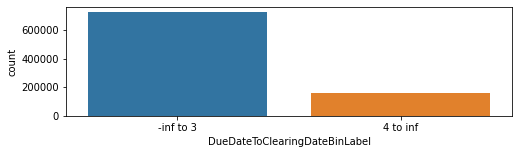

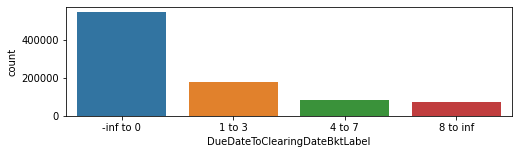

In [16]:
df, bin_class_names = setup_buckets(df, col='DueDateToClearingDate', bins=[4], sufix='Bin')
df, bucket_class_names = setup_buckets(df, col='DueDateToClearingDate', bins=[1, 4, 8], sufix='Bkt')

plot_countplot(df, cols=['DueDateToClearingDateBinLabel', 'DueDateToClearingDateBktLabel'])

## Train and Test Data

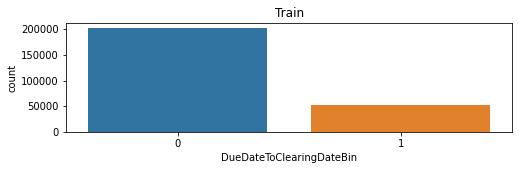

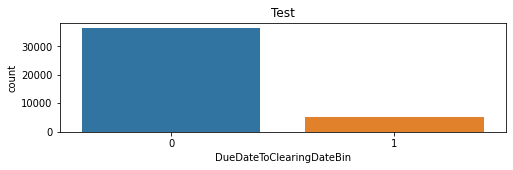

In [17]:
columns = {
    'target': [
        'DueDateToClearingDateBin',
    ],
    'numeric': [
        'AvgDaysLatePaidInvoices',
        'StdevDaysLatePaidInvoices',
        'AvgDaysLatePendingInvoices',
        'StdevDaysLatePendingInvoices',
        'RatioLatePaidInvoices',
        'TotalLatePaidInvoices',
        'TotalPaidInvoices',
        'RatioAmountPaidLateInvoices',
        'SumAmountLatePaidInvoices',
        'SumAmountPaidInvoices',
        'RatioPendingLateInvoices',
        'TotalPendingLateInvoices',
        'TotalPendingInvoices',
        'RatioAmountPendingLateInvoices',
        'SumAmountPendingLateInvoices',
        'SumAmountPendingInvoices',
        'InvoiceAmount',
        'PaymentTerm',
        'PaymentFrequency',
    ],
    'nominal': [
        'CompanyKey',
        'CorporateDivision',
        'CustomerShipToKey',
        'CustomerSoldToKey',
        'CustomerKey',
    ],
    'date': [
        'DocumentDateDay',
        'DocumentDateWeekDay',
        'DueDateDay',
        'DueDateWeekDay',
    ],
}

y_column = np.array(columns['target'])
x_column = np.array(columns['numeric'] + columns['nominal'] + columns['date'])

train, test = split_data(df, date_column='DueDate', split_date='2020-08-01', train_months=6, test_months=1)

# train = resample(train, x_column, y_column, SMOTE(sampling_strategy='auto', random_state=SEED))
# train = resample(train, x_column, y_column, ADASYN(sampling_strategy='auto', random_state=SEED))
# train = resample(train, x_column, y_column, BorderlineSMOTE(sampling_strategy='auto', kind='borderline-1', random_state=SEED))
# train = resample(train, x_column, y_column, BorderlineSMOTE(sampling_strategy='auto', kind='borderline-2', random_state=SEED))

plot_countplot(train, cols=y_column, title='Train')
plot_countplot(test, cols=y_column, title='Test')

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     36376
           1       0.77      0.56      0.65      5287

    accuracy                           0.92     41663
   macro avg       0.85      0.77      0.80     41663
weighted avg       0.92      0.92      0.92     41663



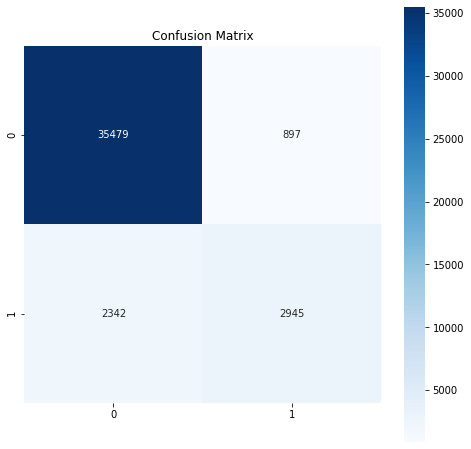

In [18]:
x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column, nominal_columns=columns['nominal'] + columns['date'])

clf = RandomForestClassifier(n_estimators=256, criterion='entropy', min_samples_leaf=1, class_weight='balanced', random_state=SEED, n_jobs=-1)
clf.fit(x_train, np.squeeze(y_train))

y_predict = clf.predict(x_test)
plot_confuncion_matrix(test[y_column].values, y_predict)

In [ ]:
# plot_feature_importance(x_column, clf.feature_importances_)

In [ ]:
# y_predict = (clf.predict_proba(x_test)[:,1] >= 0.9999).astype('int')
# plot_confuncion_matrix(test[y_column].values, y_predict)

In [ ]:
### TEMPO ###
# # test[(test['CustomerKey'] == 380664) & ((test['DocumentDate'] == '2020-07-09') | (test['DocumentDate'] == '2020-07-31'))]

# train = train[(train['CustomerKey'] == 380664) & ((train['DocumentDate'] == '2020-05-13') | (train['DocumentDate'] == '2020-06-16'))]
# test = test[(test['CustomerKey'] == 380664) & ((test['DocumentDate'] == '2020-07-09') | (test['DocumentDate'] == '2020-07-31'))]

# test[(test[y_column[0]] == 1) & (y_predict == 0)].head(50)

## Data Analysis

In [ ]:
# x_train, y_train, x_test, y_test = preprocess_data(train, test, x_column, y_column)

# df_train = np.concatenate((x_train, y_train), axis=1)
# df_test = np.concatenate((x_test, y_test), axis=1)
# df_local = np.concatenate((df_train, df_test), axis=0)

# cols = np.concatenate((x_column, y_column), axis=0)
# df_local = pd.DataFrame(df_local, columns=cols)

# profile = ProfileReport(df_local)
# profile

## Feature Selection

In [ ]:
x_column = np.array([
    # ['StdevDaysLatePaidInvoices',
    # 'AvgDaysLatePaidInvoices',
    # 'StdevDaysLatePendingInvoices',
    # 'AvgDaysLatePendingInvoices'],


    ['TotalLatePaidInvoices'],
    ['RatioLatePaidInvoices'],

    ['SumAmountLatePaidInvoices'],
    ['RatioAmountPaidLateInvoices'],

    # ['TotalPendingLateInvoices'],
    # ['RatioPendingLateInvoices'],

    # ['SumAmountPendingLateInvoices'],
    # ['RatioAmountPendingLateInvoices'],


    # ['PaymentFrequency',
    # 'PaymentTerm',
    # 'InvoiceAmount'],

    # ['DocumentDateWeekDay',
    # 'DueDateWeekDay',
    # 'DocumentDateDay',
    # 'DueDateDay'],
])


score, features = feature_selection(train, test, x_column, y_column, nominal_columns=columns['nominal'] + columns['date'], random_state=SEED)

print(f'\nFinal score: {score:.8f} >>> {features}')

## Neural Network

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split

# import tensorflow_addons as tfa
# import tensorflow as tf

# def make_model():
#     model = tf.keras.models.Sequential(name='cubricks')
#     model.add(tf.keras.layers.Input(shape=x_train.shape[1]))

#     model.add(tf.keras.layers.Dense(256, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(512, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(256, kernel_initializer='glorot_normal'))
#     model.add(tf.keras.layers.PReLU())
#     model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     # model.add(tf.keras.layers.Dense(32, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     # model.add(tf.keras.layers.Dense(64, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))
#     # # model.add(tf.keras.layers.Dropout(rate=0.1))

#     # model.add(tf.keras.layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-2)))
#     # model.add(tf.keras.layers.PReLU())
#     # model.add(tf.keras.layers.BatchNormalization(renorm=False))

#     model.add(tf.keras.layers.Dense(np.unique(y_train).shape[0], activation='softmax'))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8, amsgrad=True),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         # loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#         metrics=[tfa.metrics.F1Score(num_classes=np.unique(y_train).shape[0], average='weighted')])

#     return model


# model = make_model()
# model.summary()

# train, test = split_data_month_window(df, col='DueDate', date='2020-08-01', month_window=12)
# x_train, y_train, x_test, y_test = prepare_data(train, test, x_column, y_column, random_state=SEED)

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=SEED, stratify=y_train)

In [ ]:
# BATCH = 256
# EPOCHS = 10000
# PATIENCE = 10000

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./logs/weights.hdf5',
#                                                 monitor='val_f1_score', mode='max',
#                                                 save_best_only=True, save_weights_only=True, verbose=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=PATIENCE,
#                                                   monitor='val_f1_score', mode='max',
#                                                   restore_best_weights=True, verbose=1)

# class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train[:,0])
# class_weight = dict(zip(np.unique(y_train), class_weight))

# model = make_model()
# # model.load_weights(filepath='./logs/weights.hdf5')

# model_history = model.fit(x_train, tf.keras.utils.to_categorical(y_train),
#                           validation_data=(x_valid, tf.keras.utils.to_categorical(y_valid)),
#                           epochs=EPOCHS, batch_size=BATCH, shuffle=True,
#                           callbacks=[checkpoint, early_stopping, tensorboard],
#                           class_weight=class_weight)

In [ ]:
# def plot_model_history(history):
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     plt.figure(figsize=(15, 3))

#     for n, metric in enumerate(['loss', 'f1_score']):
#         plt.subplot(1, 2, n+1)
#         plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
#         plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle='--', label='Val')
#         plt.ylim([plt.ylim()[0], 1] if n > 0 else [0, plt.ylim()[1]])
#         plt.ylabel(metric.replace('_', ' ').capitalize())
#         plt.xlabel('Epoch')
#         plt.legend()


# plot_model_history(model_history)

In [ ]:
# model.load_weights(filepath='./logs/weights.hdf5')

# y_predict = classifier_predict(model, x_test, threshold=0.5, network=True)
# plot_confuncion_matrix(y_test, y_predict)